In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypfopt
import yfinance as yf
import pandas_datareader as pdr
import seaborn as sns
import random

In [2]:
data = {}
start_date = '2020-01-01'
end_date = '2020-12-31'

In [3]:
data['VTI'] = yf.download('VTI', period='max')
data['VTV'] = yf.download('VTV', period='max')
data['VOE'] = yf.download('VOE', period='max')
data['VBR'] = yf.download('VBR', period='max')
data['GBIL'] = yf.download('GBIL', period='max')
data['JPST'] = yf.download('JPST', period='max')
data['VNQ'] = yf.download('VNQ', period='max')
data['VPU'] = yf.download('VPU', period='max')
#data['BITO'] = yf.download('BITO', period='max')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
for ticker in data:
    data[ticker] = data[ticker].dropna()
    data[ticker] = data[ticker][start_date:end_date]

In [5]:
for ticker in data:
    data[ticker]['percentageChange'] = data[ticker]['Close'].pct_change()*10
    data[ticker]['percentageChange'] = data[ticker]['percentageChange'].fillna(0)

<AxesSubplot:xlabel='Date'>

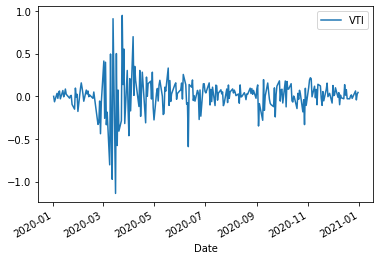

In [6]:
data['VTI'].plot(y='percentageChange', label='VTI')

In [7]:
cov_matrix = np.cov(data['VTI']['percentageChange'], data['VTV']['percentageChange'])

In [8]:
cov_matrix

array([[0.04629786, 0.04569348],
       [0.04569348, 0.04869017]])

In [9]:
onlyClosePrices = pd.DataFrame()

In [10]:
for ticker in data:
    onlyClosePrices[ticker] = data[ticker]['Close']

In [11]:
onlyClosePrices.index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2020-12-17', '2020-12-18', '2020-12-21', '2020-12-22',
               '2020-12-23', '2020-12-24', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=253, freq=None)

In [12]:
S = pypfopt.risk_models.CovarianceShrinkage(onlyClosePrices).ledoit_wolf()

In [13]:
netAssets = {}
for ticker in data:
    netAssets[ticker] = yf.Ticker(ticker).info['totalAssets']

In [14]:
netAssets['VTI']

1200912072704

In [15]:
netAssets = list(netAssets.values())

In [15]:
delta = pypfopt.black_litterman.market_implied_risk_aversion(pd.Series(netAssets), risk_free_rate=0.05796)

In [16]:
delta

0.1074068194437139

In [17]:
netAssets

{'VTI': 1200912072704,
 'VTV': 145279369216,
 'VOE': 28818311168,
 'VBR': 47090102272,
 'GBIL': 2155137536,
 'JPST': 18943338496,
 'VNQ': 82814885888,
 'VPU': 7799145984}

In [18]:
marketPrior = pypfopt.black_litterman.market_implied_prior_returns(netAssets, delta, S)

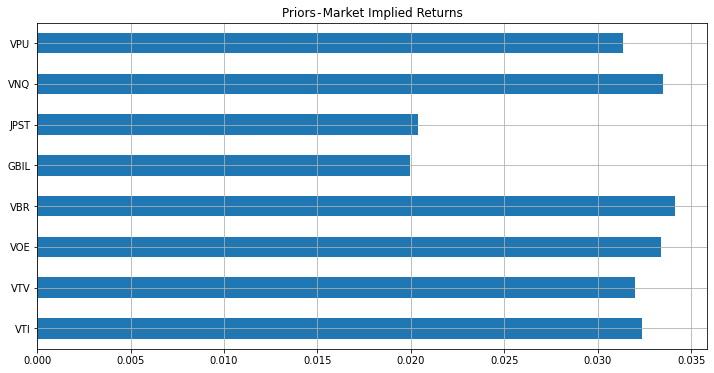

In [19]:
marketPrior.plot.barh(figsize=(12,6), title = 'Priors - Market Implied Returns',grid=True);
# plt.savefig('images/chart2', dpi=300)

In [33]:
viewDict = {}
for ticker in data:
    viewDict[ticker] = random.randrange(6,8)*0.01

In [34]:
marketPrior.to_csv('marketPrior.csv')

In [35]:
bl = pypfopt.black_litterman.BlackLittermanModel(S, pi=marketPrior, absolute_views=viewDict, rho=delta)

In [36]:
bl.bl_returns()

VTI     0.056502
VTV     0.057270
VOE     0.061421
VBR     0.061915
GBIL    0.044967
JPST    0.045357
VNQ     0.062693
VPU     0.058429
dtype: float64

In [43]:
confidence = []
for ticker in data:
    confidence.append(random.randrange(6,8)*0.01)

In [44]:
bl_confi = pypfopt.BlackLittermanModel(S, absolute_views=viewDict, omega="idzorek", rho=delta, view_confidences=confidence)

In [45]:
bl_return_confi = bl_confi.bl_returns()
bl_return_confi.name = 'BL Returns with Confidence'

In [46]:
S_bl_confi = bl_confi.bl_cov()

In [49]:
ef = pypfopt.EfficientFrontier(bl_return_confi, S_bl_confi, weight_bounds=(0, 0.2))

In [61]:
# ef.add_objective('Sharpe', 'max')
#weights = ef.min_volatility()
ef.portfolio_performance(verbose=True)

Expected annual return: 1.2%
Annual volatility: 21.1%
Sharpe Ratio: -0.04


(0.012479679663488, 0.21075013312159996, -0.035683585225414205)

In [55]:
wt_min_vola = pd.DataFrame([weights], columns=weights.keys()).T*100

In [56]:
print ('Weights in Percentage ********************')
print(wt_min_vola.round(4))

Weights in Percentage ********************
         0
VTI   20.0
VTV   20.0
VOE    0.0
VBR    0.0
GBIL  20.0
JPST  20.0
VNQ    0.0
VPU   20.0


In [57]:
from keras.models import load_model

In [60]:
model = load_model('VTI.h5')

In [59]:
model.pr